In [218]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import time

In [219]:
df = pd.read_csv("~/Projects/omscs/ML/train.csv")
df = df.dropna()
df = df.ffill()
df = df.bfill()
df.shape

(2000, 21)

/Users/nitarora/Projects/KBAI-Assignment1/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


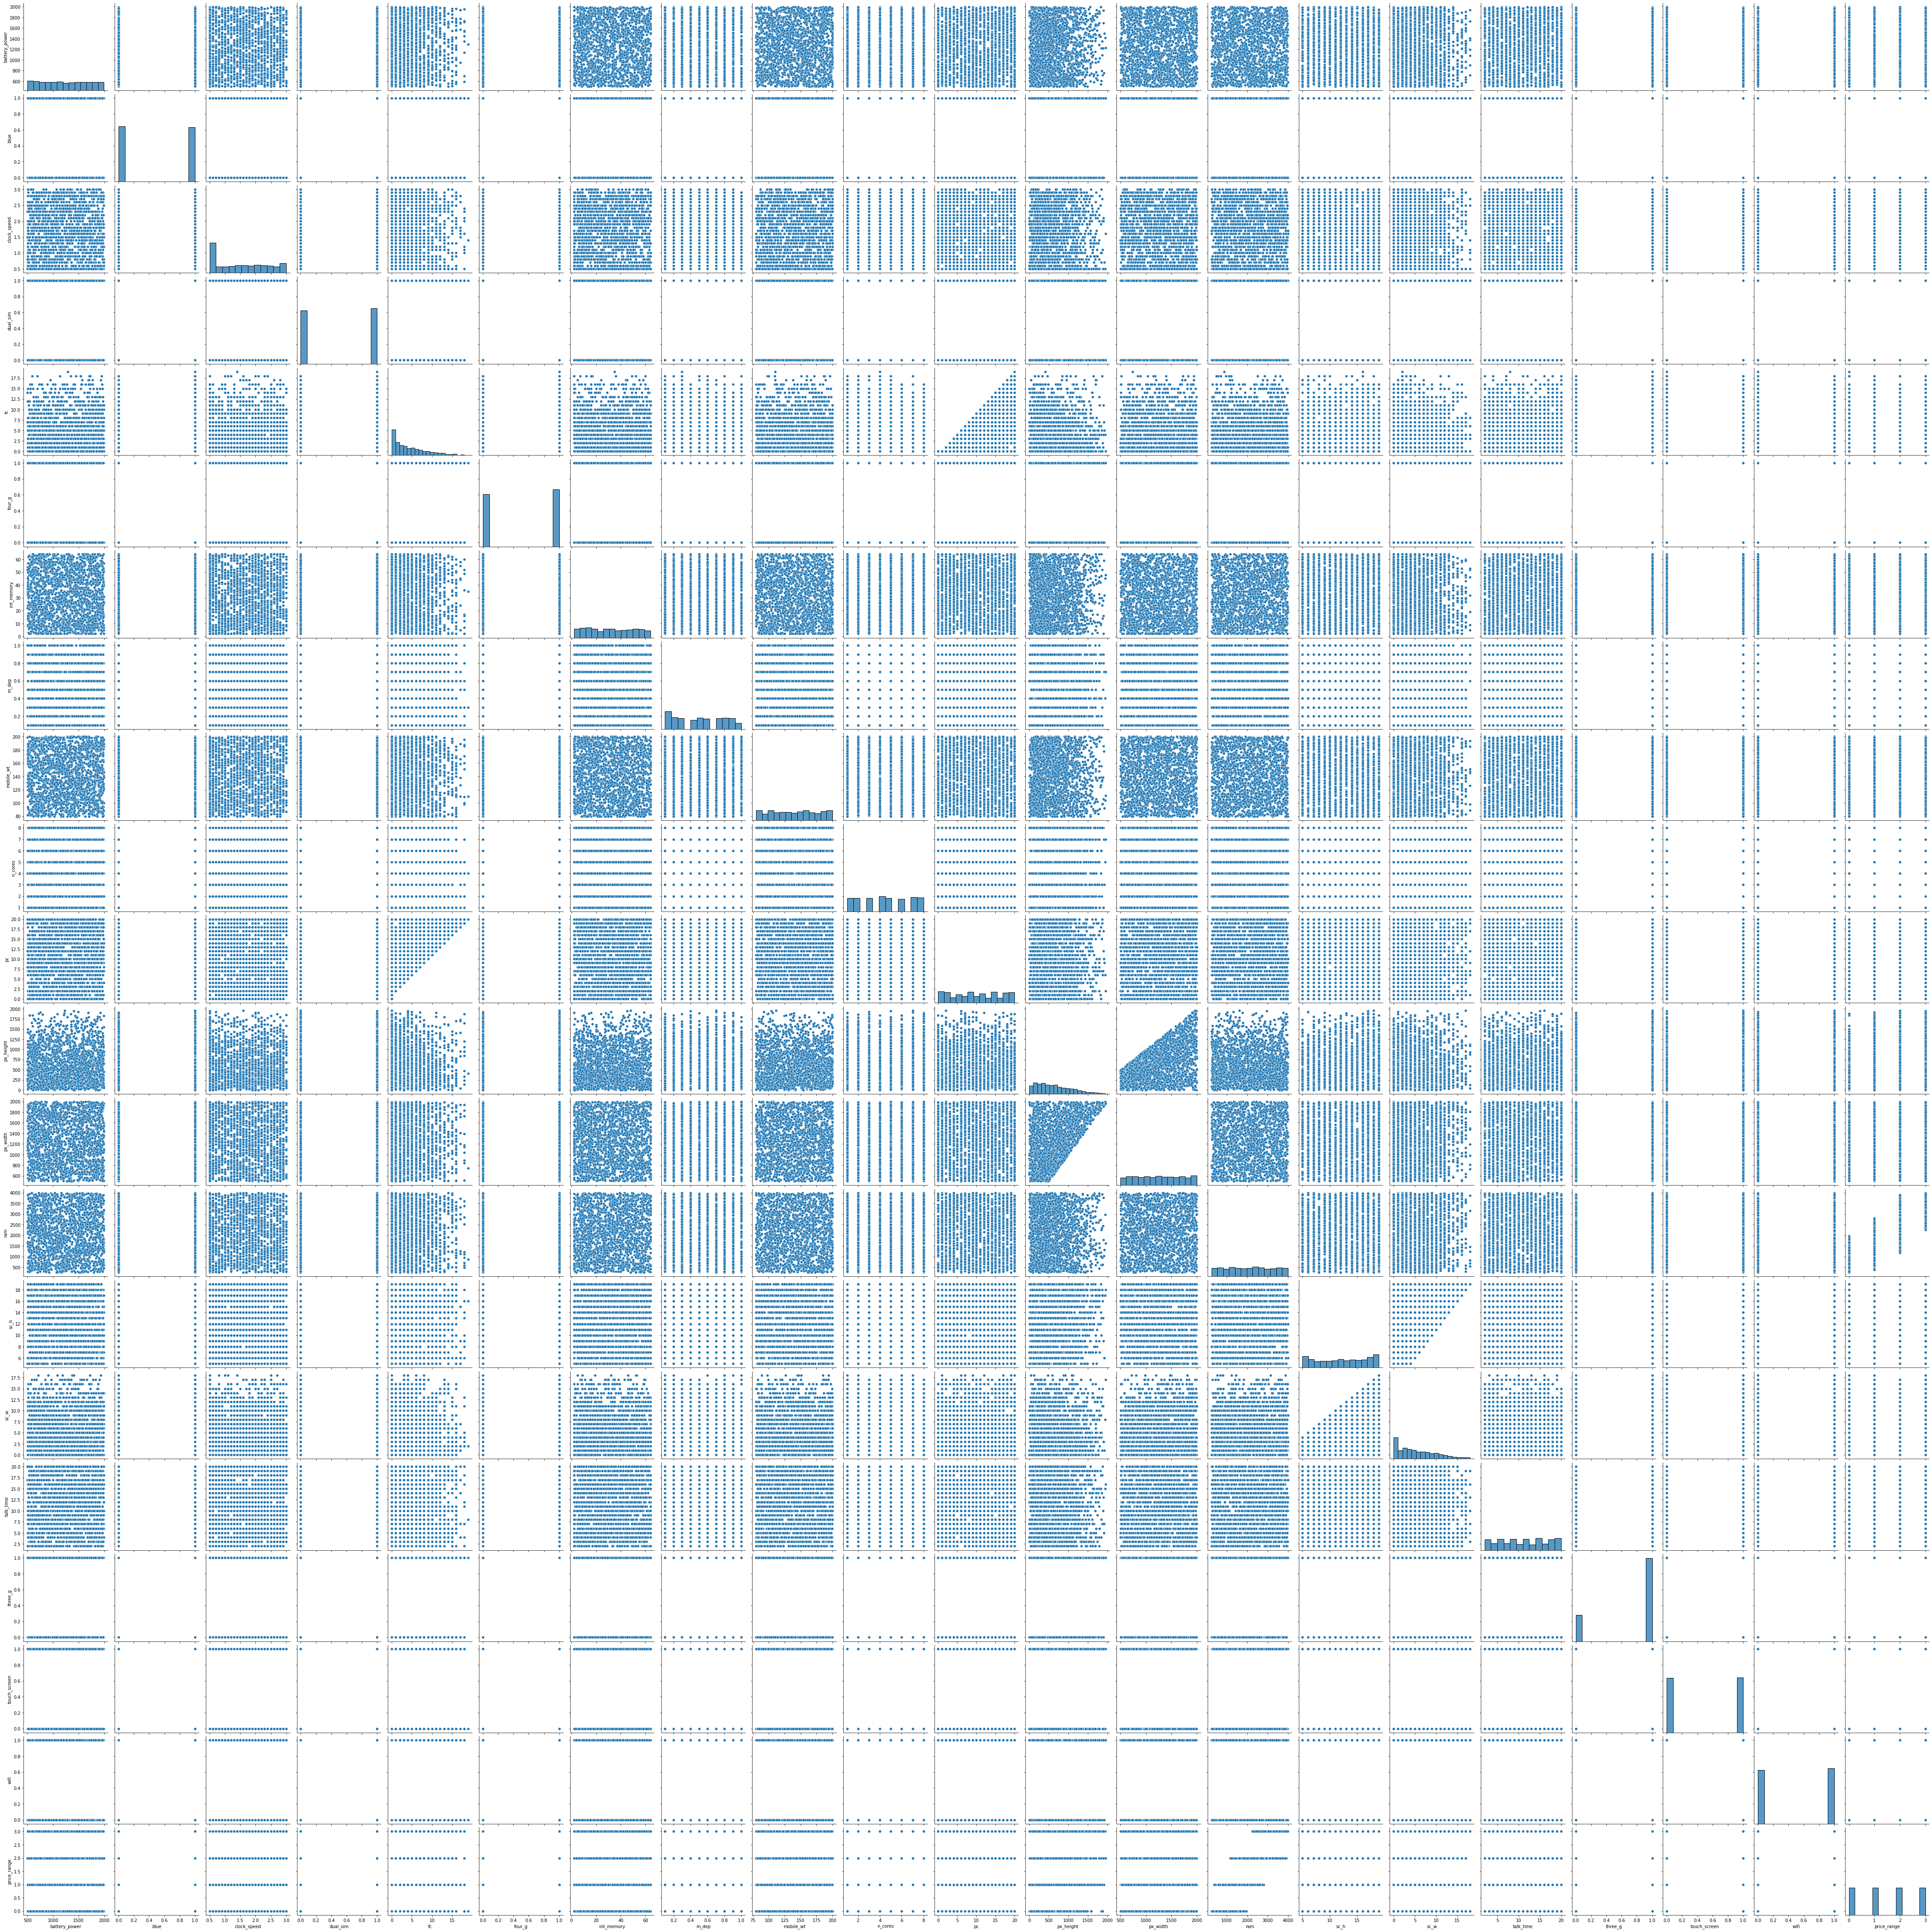

In [251]:
sns.pairplot(df, height=3)

In [220]:
# Convert the output class into buckets of low and high. Low is 0 and high is 1
price_range = df[['price_range']].to_numpy()
price_range[price_range<=1] = 0
price_range[price_range>1] = 1
y_new = pd.DataFrame(price_range, columns=['price_range'])

In [221]:
X = df.drop(columns=['price_range'])
y = y_new
y = df[['price_range']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# df[['price_range']].value_counts()

In [222]:
clf = DecisionTreeClassifier()
start_time = time.time()
clf.fit(x_train, y_train)
print(f"DT Normal Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred = clf.predict(x_test)
print(f"DT Normal Model: Fit Time: {time.time() - start_time}")
print(f"Number of Nodes in the tree {clf.tree_.node_count}")
print(f"Features of Model Tree are : dir{dir(clf.tree_)}")

DT Normal Model: Fit Time: 0.01773977279663086
DT Normal Model: Fit Time: 0.0027849674224853516
Number of Nodes in the tree 281
Features of Model Tree are : dir['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', 'apply', 'capacity', 'children_left', 'children_right', 'compute_feature_importances', 'compute_partial_dependence', 'decision_path', 'feature', 'impurity', 'max_depth', 'max_n_classes', 'n_classes', 'n_features', 'n_leaves', 'n_node_samples', 'n_outputs', 'node_count', 'predict', 'threshold', 'value', 'weighted_n_node_samples']


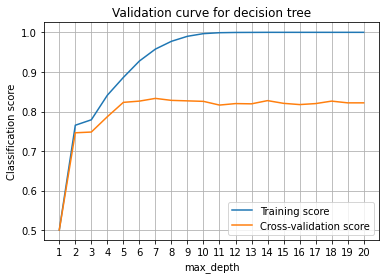

In [244]:
# Initial Validation Curve
depth_range = np.arange(20) + 1
train_scores, test_scores = validation_curve(clf, x_train, y_train, param_name="max_depth", param_range=depth_range, cv=5)

plt.figure()
plt.xticks(depth_range)
plt.plot(depth_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(depth_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for decision tree')
plt.xlabel('max_depth')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()



In [223]:
from sklearn.model_selection import cross_val_score
crossValScores = cross_val_score(clf, X, y, cv=5)
print("Cross Valuation Scores for unpruned tree are ", crossValScores)
print("Mean accuracy score is ", crossValScores.mean())
print("Std accuracy score is ", crossValScores.std())

Cross Valuation Scores for unpruned tree are  [0.8425 0.8225 0.815  0.8275 0.8375]
Mean accuracy score is  0.8290000000000001
Std accuracy score is  0.009949874371066224


In [224]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       101
           1       0.75      0.78      0.76       107
           2       0.76      0.78      0.77        94
           3       0.93      0.89      0.91        98

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



In [225]:
print(confusion_matrix(y_test, y_pred))

[[89 12  0  0]
 [11 83 12  1]
 [ 0 15 73  6]
 [ 0  0 11 87]]


In [226]:
# To make the results deterministic - we need to use random_state
pipelineA = Pipeline([('scaler', StandardScaler()), 
#                       ('Cull1',SelectFromModel(RandomForestClassifier(random_state=1),threshold='median')),
#                       ('Cull2',SelectFromModel(RandomForestClassifier(random_state=2),threshold='median')),
#                       ('Cull3',SelectFromModel(RandomForestClassifier(random_state=3),threshold='median')),
#                       ('Cull4',SelectFromModel(RandomForestClassifier(random_state=4),threshold='median')),
                      ('dt', DecisionTreeClassifier())])
start_time = time.time()
p = pipelineA.fit(x_train, y_train)
print(f"DT Pipeline Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipelineA = p.predict(x_test)
print(f"DT Pipeline Model: Predict Time: {time.time() - start_time}")
# print(confusion_matrix(y_test, y_pred_pipelineA))
# print(classification_report(y_test, y_pred_pipelineA))

DT Pipeline Model: Fit Time: 0.01701807975769043
DT Pipeline Model: Predict Time: 0.0034003257751464844


In [248]:
# Cross validation 
# Use np.arange(1, 20, 5)
# => 1, 5, 10, 15, 20
ccp_alphas = [-1,-1e-3,-(1e-3)*10**-0.5, -1e-2, -(1e-2)*10**-0.5,-1e-1,-(1e-1)*10**-0.5, 0, (1e-1)*10**-0.5,1e-1,(1e-2)*10**-0.5,1e-2,(1e-3)*10**-0.5,1e-3]
param = {'dt__max_depth': np.arange(1, 20), 'dt__criterion': ['gini', 'entropy'], 'dt__ccp_alpha': ccp_alphas, 'dt__class_weight': ['balanced']}
clf_cv = GridSearchCV(pipelineA, n_jobs=-1, param_grid=param, refit=True, cv=5, return_train_score=True)
start_time = time.time()
clf_cv = clf_cv.fit(x_train, y_train)
print(f"DT CV Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline_cv = clf_cv.predict(x_test)
print(f"DT CV Model: Predict Time: {time.time() - start_time}")
clf_cv.best_params_


DT CV Model: Fit Time: 11.058081865310669
DT CV Model: Predict Time: 0.0020720958709716797


{'dt__ccp_alpha': 0.00031622776601683794,
 'dt__class_weight': 'balanced',
 'dt__criterion': 'entropy',
 'dt__max_depth': 18}

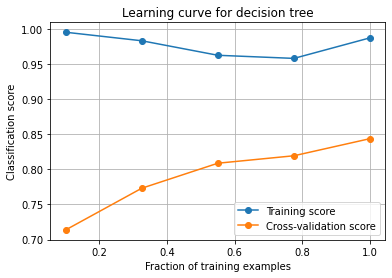

In [247]:
# Initial learning curve
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(clf_cv, x_train, y_train, train_sizes=train_sizes, cv=5)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for decision tree')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

In [228]:
start_time = time.time()
print(classification_report(y_test, y_pred_pipeline_cv))
print(clf_cv.best_score_, clf_cv.best_params_)
print(f"DT CV classification_report time: {time.time() - start_time}")
# print(clf_cv.cv_results_)
sc_df = pd.DataFrame(clf_cv.cv_results_)
sc_df.dropna(inplace=True)
sc_df.sort_values(by="rank_test_score", ascending=True)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       101
           1       0.85      0.77      0.81       107
           2       0.75      0.84      0.79        94
           3       0.92      0.88      0.90        98

    accuracy                           0.85       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.85      0.86       400

0.849375 {'dt__ccp_alpha': 0.001, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_depth': 13}
DT CV classification_report time: 0.007337093353271484


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
525       0.035038      0.004355         0.010404        0.002295   
298       0.038183      0.009746         0.005796        0.002207   
484       0.030416      0.005097         0.004451        0.000892   
413       0.027987      0.003447         0.006100        0.003154   
293       0.032468      0.007651         0.004742        0.001185   
..             ...           ...              ...             ...   
380       0.021742      0.004842         0.006918        0.002045   
475       0.018510      0.003644         0.003596        0.000221   
456       0.014947      0.001605         0.004709        0.002104   
494       0.020381      0.002605         0.005324        0.001272   
266       0.024360      0.005377         0.006624        0.001660   

    param_dt__ccp_alpha param_dt__class_weight param_dt__criterion  \
525               0.001               balanced             entropy   
298                   0               balanced             entropy   
484         0.000316228               balanced             entropy   
413          0.00316228               balanced             entropy   
293                   0               balanced             entropy   
..                  ...                    ...                 ...   
380          0.00316228               balanced                gini   
475         0.000316228               balanced             entropy   
456         0.000316228               balanced                gini   
494               0.001               balanced                gini   
266                   0               balanced                gini   

    param_dt__max_depth                                             params  \
525                  13  {'dt__ccp_alpha': 0.001, 'dt__class_weight': '...   
298                  14  {'dt__ccp_alpha': 0, 'dt__class_weight': 'bala...   
484                  10  {'dt__ccp_alpha': 0.00031622776601683794, 'dt_...   
413                  15  {'dt__ccp_alpha': 0.0031622776601683794, 'dt__...   
293                   9  {'dt__ccp_alpha': 0, 'dt__class_weight': 'bala...   
..                  ...                                                ...   
380                   1  {'dt__ccp_alpha': 0.0031622776601683794, 'dt__...   
475                   1  {'dt__ccp_alpha': 0.00031622776601683794, 'dt_...   
456                   1  {'dt__ccp_alpha': 0.00031622776601683794, 'dt_...   
494                   1  {'dt__ccp_alpha': 0.001, 'dt__class_weight': '...   
266                   1  {'dt__ccp_alpha': 0, 'dt__class_weight': 'bala...   

     split0_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
525           0.843750  ...         0.849375        0.012087                1   
298           0.831250  ...         0.848750        0.012748                2   
484           0.837500  ...         0.848125        0.009186                3   
413           0.846875  ...         0.847500        0.007500                4   
293           0.831250  ...         0.847500        0.012717                5   
..                 ...  ...              ...             ...              ...   
380           0.503125  ...         0.500625        0.001250              253   
475           0.503125  ...         0.500625        0.001250              253   
456           0.503125  ...         0.500625        0.001250              253   
494           0.503125  ...         0.500625        0.001250              253   
266           0.503125  ...         0.500625        0.001250              253   

     split0_train_score  split1_train_score  split2_train_score  \
525            1.000000            1.000000            1.000000   
298            1.000000            1.000000            1.000000   
484            1.000000            1.000000            0.999219   
413            0.983594            0.987500            0.985156   
293            0.999219            0.998437            0.992969   
..                  ...

In [ ]:
# from sklearn import tree
# print(tree.export_text(clf))
# sc_df.columns
# sc_df = sc_df.drop_duplicates(subset=['mean_test_score', 'mean_train_score', 'param_dt__max_depth'], keep="last")
# sc_df.drop(sc_df[sc_df['param_dt__criterion'] == 'gini'].index, inplace = True) 
sc_df.plot(x='param_dt__max_depth', y=['mean_test_score', 'mean_train_score'], style='o', grid=True)
clf_cv.best_params_
sc_df

In [213]:
def plot_grid_search_validation_curve(grid, param_to_vary, title='Validation Curve', ylim=None, xlim=None, log=None):
    """Plots train and cross-validation scores from a GridSearchCV instance's
    best params while varying one of those params."""

    df_cv_results = pd.DataFrame(grid.cv_results_)
    train_scores_mean = df_cv_results['mean_train_score']
    valid_scores_mean = df_cv_results['mean_test_score']
    train_scores_std = df_cv_results['std_train_score']
    valid_scores_std = df_cv_results['std_test_score']

    param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
    param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    train_scores_mean = np.array(train_scores_mean).reshape(*param_ranges_lengths)
    valid_scores_mean = np.array(valid_scores_mean).reshape(*param_ranges_lengths)
    train_scores_std = np.array(train_scores_std).reshape(*param_ranges_lengths)
    valid_scores_std = np.array(valid_scores_std).reshape(*param_ranges_lengths)

    param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

    slices = []
    for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

    train_scores_mean = train_scores_mean[tuple(slices)]
    valid_scores_mean = valid_scores_mean[tuple(slices)]
    train_scores_std = train_scores_std[tuple(slices)]
    valid_scores_std = valid_scores_std[tuple(slices)]

    plt.clf()

    plt.title(title)
    plt.xlabel(param_to_vary)
    plt.ylabel('Score')

    if (ylim is None):
        plt.ylim(0.0, 1.1)
    else:
        plt.ylim(*ylim)

    if (not (xlim is None)):
        plt.xlim(*xlim)

    lw = 2

    plot_fn = plt.plot
    if log:
        plot_fn = plt.semilogx

    param_range = param_ranges[param_to_vary_idx]
#     if (not isinstance(param_range[0], numbers.Number)):
#         param_range = [str(x) for x in param_range]
    plot_fn(param_range, train_scores_mean, label='Training score', color='r', lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r', lw=lw)
    plot_fn(param_range, valid_scores_mean, label='Cross-validation score', color='b', lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color='b', lw=lw)

    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


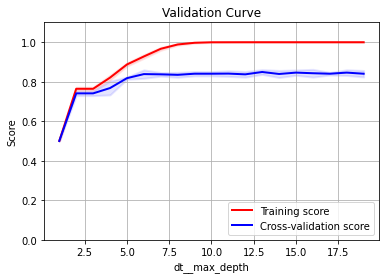

None
{'dt__ccp_alpha': 0.001, 'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_depth': 13}


In [246]:
print(plot_grid_search_validation_curve(clf_cv, 'dt__max_depth', log=False))
print(clf_cv.best_params_)

In [215]:
import numpy as np
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


title = "Learning Curves (Decision Tree)"
# cv = ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None)
# plot_learning_curve(clf_cv.estimator, title, X, y,  ylim=(0.5, 1.01), cv=cv, n_jobs=-1)

'So here, we see that by increasing the max_depth param, the training_score becomes better. Variance increases with increase in training size and max_depth\nBut with low max_depth value, we see that the training score goes down with increase in size as we are now underfitting the data and pruning too much.'

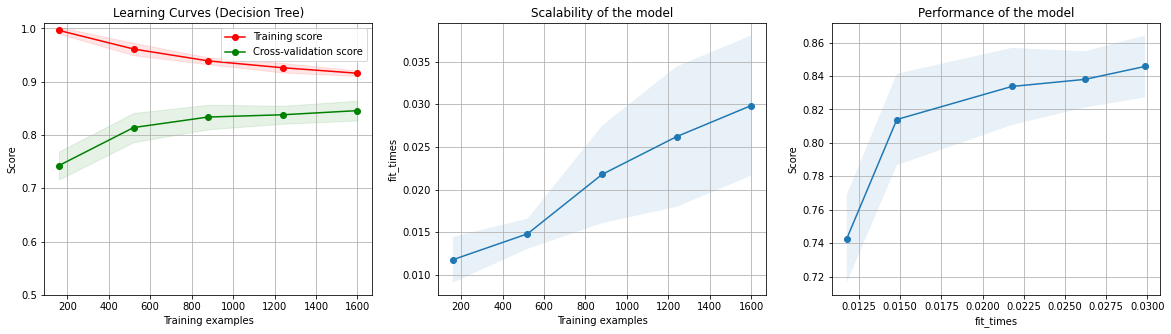

In [216]:
dt_classifier = DecisionTreeClassifier(criterion="entropy", max_depth=6, class_weight="balanced")
plot_learning_curve(dt_classifier, title, X, y, ylim=(0.5, 1.01), cv=cv, n_jobs=-1)

"""So here, we see that by increasing the max_depth param, the training_score becomes better. Variance increases with increase in training size and max_depth
But with low max_depth value, we see that the training score goes down with increase in size as we are now underfitting the data and pruning too much."""

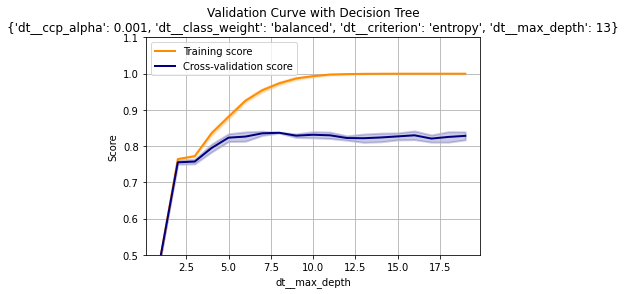

'In this case, we see the increase in max_depth yields the same result after some time. Either we created all the nodes and reached max node size'

In [239]:
from sklearn.model_selection import validation_curve

param_range = np.arange(1, 20, 1)
train_scores, test_scores = validation_curve(clf_cv.estimator, X, y, param_name="dt__max_depth", param_range=param_range,scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title(f"Validation Curve with Decision Tree\n{clf_cv.best_params_}")
plt.xlabel(r"dt__max_depth")
plt.ylabel("Score")
plt.ylim(0.5, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)
plt.legend(loc="best")
plt.grid()
plt.show()
"""In this case, we see the increase in max_depth yields the same result after some time. Either we created all the nodes and reached max node size"""

In [240]:
clf_cv.estimator.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('dt', DecisionTreeClassifier())],
 'verbose': False,
 'scaler': StandardScaler(),
 'dt': DecisionTreeClassifier(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'dt__ccp_alpha': 0.0,
 'dt__class_weight': None,
 'dt__criterion': 'gini',
 'dt__max_depth': None,
 'dt__max_features': None,
 'dt__max_leaf_nodes': None,
 'dt__min_impurity_decrease': 0.0,
 'dt__min_impurity_split': None,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2,
 'dt__min_weight_fraction_leaf': 0.0,
 'dt__presort': 'deprecated',
 'dt__random_state': None,
 'dt__splitter': 'best'}

In [241]:
import time
import copy

# Lets make a time chart for different test train fractions
def timing_curve(clf, X, Y, train_sizes=np.arange(0.1, 1., 0.1)):
    out = {
        'train_size': [],
        'fit_time': [],
        'pred_time':  [],
    }
    
    for frac in train_sizes:
        clf_clone = copy.copy(clf)
        
        x_train,x_test, y_train, y_test = train_test_split(X, Y, test_size=frac, random_state=1)
        out['train_size'].append(x_train.shape[0])
        
        st = time.time()
        np.random.seed(55)
        clf_clone.fit(x_train, y_train)
        out['fit_time'].append(time.time() - st)
        
        st = time.time()
        clf_clone.predict(X_test)
        out['pred_time'].append(time.time() - st)
    
    out_df = pd.DataFrame(out)
    out_df['fit_time_per_samp'] = out_df['fit_time'] / out_df['train_size']
    out_df['pred_time_per_samp'] = out_df['pred_time'] / out_df['train_size']
    out_df = out_df.set_index('train_size')
    
    return out_df

def save_timing_curve(timing_df, dataset, estimator_type, results_dir='./results/', extras=''):
    """Saves a GridSearchCV or RandomizedSearchCV result to a file"""
    tz = timezone('US/Eastern')
    date = datetime.now(tz).isoformat(timespec='minutes', sep='_').replace(':', '-')
    filename = 'timing_%s_%s_%s_%s' % (dataset, estimator_type, date, extras)
    path = Path(results_dir + filename + '.pkl')
    joblib.dump(timing_df, path)

In [242]:
import copy
clone = copy.copy(clf_cv)
clone
np.arange(0.1, 1., 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [243]:
tc_df = timing_curve(clone, X, y)
tc_df.plot()

ValueError: X has 100 features, but this StandardScaler is expecting 20 features as input.

In [ ]:
(tc_df / tc_df.iloc[0])[['fit_time', 'fit_time_per_samp']].plot()
(tc_df / tc_df.iloc[0])

<AxesSubplot:xlabel='train_size'>

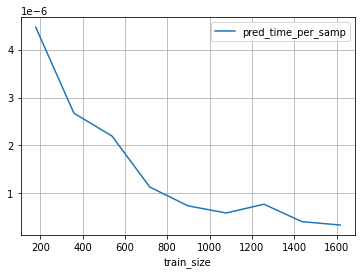

In [166]:
tc_df[['pred_time_per_samp']].plot(grid=True)

In [19]:
# feature_columns = (df.columns.tolist())
# feature_columns.remove('price_range')
# dot_data = StringIO()

# out_file = export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_columns, class_names=['Very Low', 'Low', 'High','Very High'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png('output.png')

# Image(graph.create_png())

In [ ]:
# DT Pruning Mechanism

In [18]:
# fig = plt.figure(figsize=(25, 20))
# _ = tree.plot_tree(clf, feature_names=df.columns.tolist().remove('price_range'), class_names=['0','1', '2', '3'], filled=True)
# fig.savefig('dt_plot_1.png', dpi=1200)
# from dtreeviz.trees import dtreeviz
# viz = dtreeviz(clf, X, y['price_range'],
#                 target_name="price_range",
#                 feature_names=df.columns.tolist(),
#                 class_names=['very_low','low', 'high', 'very_high'])
# viz.view()
